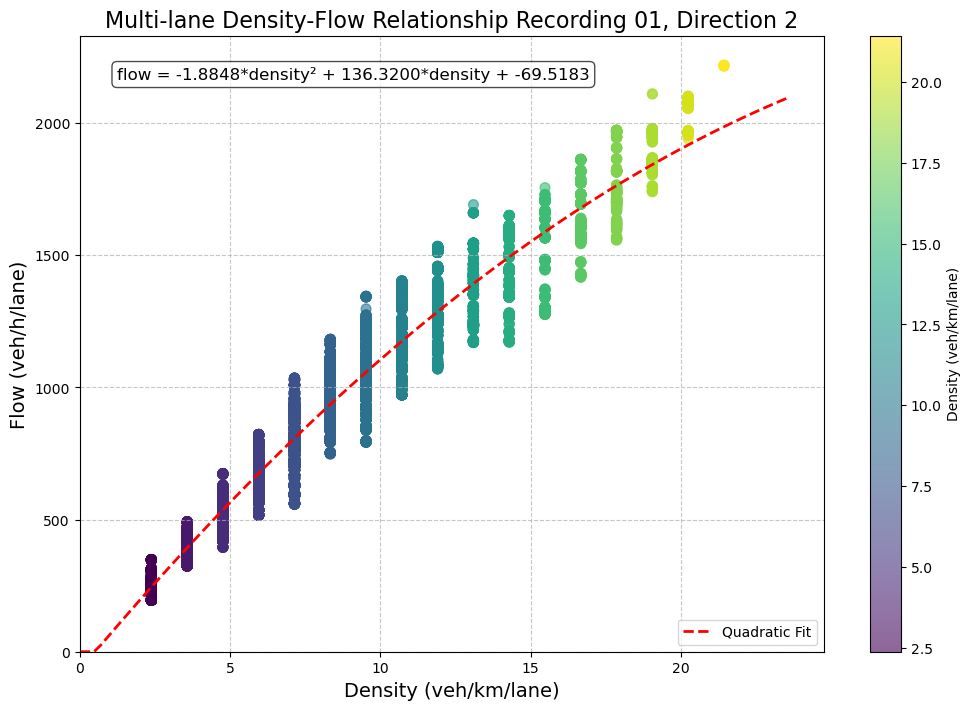

Number of data points: 22109
Average density: 8.3389 veh/km/lane
Average flow: 911.1565 veh/h/lane
Average speed: 110.3524 km/h
Number of lanes: 2


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import os

HIGHD_DIR = "D:\\AppliedGroupCW3\\Collaberate\\highD-dataset-master\\Python\\data"


def load_highd_data(recording_id):
    # tracks metadata
    tracks_meta_path = os.path.join(HIGHD_DIR, f"{recording_id}_tracksMeta.csv")
    tracks_meta = pd.read_csv(tracks_meta_path)
    
    # tracks data
    tracks_path = os.path.join(HIGHD_DIR, f"{recording_id}_tracks.csv")
    tracks = pd.read_csv(tracks_path)
    
    # recording metadata
    recording_meta_path = os.path.join(HIGHD_DIR, f"{recording_id}_recordingMeta.csv")
    recording_meta = pd.read_csv(recording_meta_path)
    
    return tracks_meta, tracks, recording_meta


def calculate_traffic_measures_multilane(tracks_df, tracks_meta_df, driving_direction=1, section_length=420):
    direction_map = tracks_meta_df[['id', 'drivingDirection']].set_index('id').to_dict()['drivingDirection']
    tracks_df = tracks_df.copy()  
    tracks_df['drivingDirection'] = tracks_df['id'].map(direction_map)

    direction_tracks = tracks_df[tracks_df['drivingDirection'] == driving_direction].copy() 
    
    if len(direction_tracks) == 0:
        print(f"Warning: No data found for direction {driving_direction}")
        return pd.DataFrame()
    

    max_frame = direction_tracks['frame'].max()
    
    results = []
    
    for frame in range(int(max_frame) + 1):

        frame_data = direction_tracks[direction_tracks['frame'] == frame].copy()  
        if len(frame_data) == 0:
            continue
            
        vehicle_count = len(frame_data)
        
        lane_count = len(frame_data['laneId'].unique())
        if lane_count == 0:
            continue
        
        density = vehicle_count / (lane_count * (section_length / 1000)) 

        frame_data.loc[:, 'speed'] = frame_data['xVelocity'].abs() 
        
        avg_speed = frame_data['speed'].mean()

        flow = density * avg_speed * 3.6  
        
        results.append({
            'frame': frame,
            'time': frame / 25.0,  
            'density': density,
            'flow': flow,
            'avg_speed': avg_speed,
            'lane_count': lane_count
        })
    
    return pd.DataFrame(results)

def create_density_flow_diagram(measures_df, title=""):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    x = measures_df['density'].values
    y = measures_df['flow'].values
    
    scatter = ax.scatter(x, y, c=x, s=50, alpha=0.6, cmap='viridis')
    plt.colorbar(scatter, label='Density (veh/km/lane)')

    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    
    x_fit = np.linspace(0, max(x) * 1.1, 100)
    y_fit = p(x_fit)
    
    y_fit = np.maximum(y_fit, 0)
    
    ax.plot(x_fit, y_fit, "r--", linewidth=2, label='Quadratic Fit')
    
    equation = f"flow = {z[0]:.4f}*density² + {z[1]:.4f}*density + {z[2]:.4f}"
    ax.text(0.05, 0.95, equation, transform=ax.transAxes, 
             verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    ax.set_xlabel('Density (veh/km/lane)', fontsize=14)
    ax.set_ylabel('Flow (veh/h/lane)', fontsize=14)
    ax.set_title(f'Multi-lane Density-Flow Relationship {title}', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    
    plt.legend()
    return fig, ax

def analyze_multilane_direction(recording_id, driving_direction=1, section_length=420):
    tracks_meta, tracks, _ = load_highd_data(recording_id)

    measures_df = calculate_traffic_measures_multilane(
        tracks, tracks_meta, driving_direction, section_length
    )
    
    
    title = f"Recording {recording_id}, Direction {driving_direction}"
    fig, ax = create_density_flow_diagram(measures_df, title)
    
    plt.savefig(f"multilane_density_flow_highd_{recording_id}_dir{driving_direction}.png", 
               dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Number of data points: {len(measures_df)}")
    print(f"Average density: {measures_df['density'].mean():.4f} veh/km/lane")
    print(f"Average flow: {measures_df['flow'].mean():.4f} veh/h/lane")
    print(f"Average speed: {measures_df['avg_speed'].mean() * 3.6:.4f} km/h")
    print(f"Number of lanes: {measures_df['lane_count'].mode()[0]}")
    
    return measures_df


measures_df = analyze_multilane_direction("01", driving_direction=2)

